In this notebook we will compare how a network trained on multi-tasks compares to that of a single task.
The dataset used is ESC-50 (https://github.com/karoldvl/ESC-50).
The multi-task model will learn to classify the spectral centroids as a secondary task in parallel to the main task of classifying the audio by source (dog, rooster, hand saw etc.).  
We refer to original (50) classes as 'source class' and spectral centroid classes as 'spec class'.

In [2]:
%matplotlib notebook

import numpy as np
import os
import tensorflow as tf
from scipy import ndimage
import time
import matplotlib.pyplot as plt

import model_mtl as m #import multi-task learning CNN model
import model_stl as s #import single-task learning CNN model

dataset_path = "C:/Users/Huz/Documents/python_scripts/ESC50_multitask/ESC-50-spec"
#aug_path = "C:/Users/Huz/Documents/python_scripts/ESC50_overload/ESC-50-flip" #augmented dataset

IMAGE_WIDTH= 50  #pixel width ie. time bins
IMAGE_HEIGHT = 37 #pixel height ie. frequency bins.
NUM_CHANNELS = 1 #no of image channels
#N_LABELS = 50 #no.of classes. this is already loaded from the model file!
#N_SPEC_LABELS = 8 #no. of spectral centroid labels. this is already loaded from the model file!

#np.set_printoptions(threshold=np.nan)  #if want to see full output of big arrays in Jupyter notebook

In [2]:
def time_taken(elapsed):
    """To format time taken in hh:mm:ss. Use with time.monotic()"""
    m, s = divmod(elapsed, 60)
    h, m = divmod(m, 60)
    return "%d:%02d:%02d" % (h, m, s)

def get_subdirs(a_dir):
    """ Returns a list of sub directory names in a_dir""" 
    return [name for name in os.listdir(a_dir)
            if (os.path.isdir(os.path.join(a_dir, name)) and not (name.startswith('.')))]

def getStringMatch(string,match,steps_away):
    """more general string matching routine than getFold.
    string: input string to search through
    match: the string you want to find
    steps_away: no. of positions way from the matched string that the actual letter/no. wanted lies. can take negative.
    """
    pos = string.index(match)
    return string[pos + steps_away]

def get_fold(string):
    """get fold no. from ESC-50 dataset using the filename. Labels #1-5"""
    label_pos = string.index("-")
    return string[label_pos-1]

def get_train_test(data,test_proportion):
    """Splits data into arrays of test and training samples according to test_proportion
    Can use train_test_split from sklearn.model_selection library for similar functionality 
    """  
    test_samples = random.sample(data, int(len(data) * test_proportion)) #randomly pick out test samples
    train_samples = list(set(data) - set(test_samples)) #the compliment will be used for training
    return train_samples, test_samples

def fetch_files_kfold(spec_dir):
    """Returns lists of full pathnames of datafiles and their respective (numerical) labels and (Piczak's) folds"""
    filepaths = []
    labels = []
    folds = []
    i = 0
    class_folders = get_subdirs(spec_dir)
    for folder in class_folders:
        class_files = os.listdir(spec_dir + "/" + folder)
        fold = [int(get_fold(fp)) for fp in class_files]
        class_files = [spec_dir + "/" + folder + "/" + fp for fp in class_files]
        class_labels = [i] * len(class_files)
        
        folds.extend(fold)
        filepaths.extend(class_files)
        labels.extend(class_labels)
        i += 1
    return filepaths, labels, folds

def fetch_files_holdout(spec_dir,hold_prop,seed):
    """Returns lists of full pathnames of datafiles and their respective (numerical) labels, split to training and test sets
    hold_prop: proportion between 0-1 to hold out as test set in each class
    seed: random seed for pseudorandom number generator. Use same seed to maintain same test set.
    """
    from sklearn.model_selection import train_test_split
    
    train_filepaths = []
    test_filepaths = []
    train_labels = []
    test_labels = []
    i = 0
    class_folders = get_subdirs(spec_dir)
    
    for folder in class_folders:
        class_files = os.listdir(spec_dir + "/" + folder)
        class_files = [spec_dir + "/" + folder + "/" + fp for fp in class_files]
        class_labels = [i] * len(class_files)

        train_files, test_files, train_label, test_label = train_test_split(class_files, class_labels,
                                                                              test_size=hold_prop, random_state=seed)
        train_filepaths.extend(train_files)
        test_filepaths.extend(test_files)
        train_labels.extend(train_label)
        test_labels.extend(test_label)
        i += 1
    return train_filepaths,test_filepaths,train_labels,test_labels

def fetch_files(spec_dir):
    """Returns lists of full pathnames of datafiles and their respective (numerical) labels"""
    filepaths = []
    labels = []
    i = 0
    class_folders = get_subdirs(spec_dir)
    for folder in class_folders:
        class_files = os.listdir(spec_dir + "/" + folder)
        class_files = [spec_dir + "/" + folder + "/" + fp for fp in class_files]
        class_labels = [i] * len(class_files)
        
        filepaths.extend(class_files)
        labels.extend(class_labels)
        i += 1
    return filepaths, labels

In [3]:
# firstly get the test/train sets

train_filepaths,test_filepaths,train_labels,test_labels = fetch_files_holdout(dataset_path,0.2,42)

In [4]:
# now we get the labels for spectral centroids

spec_train_labels = [int(getStringMatch(i[::-1],"_",-1)) for i in train_filepaths]
spec_test_labels = [int(getStringMatch(i[::-1],"_",-1)) for i in test_filepaths]

<IPython.core.display.Javascript object>


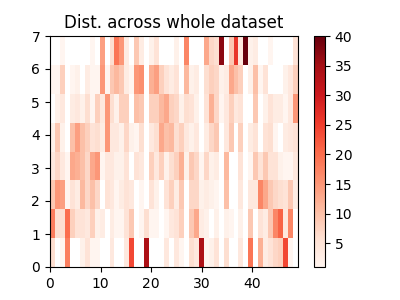

<IPython.core.display.Javascript object>


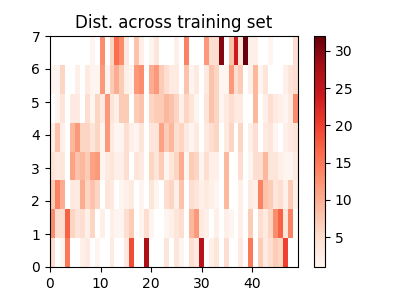

<IPython.core.display.Javascript object>


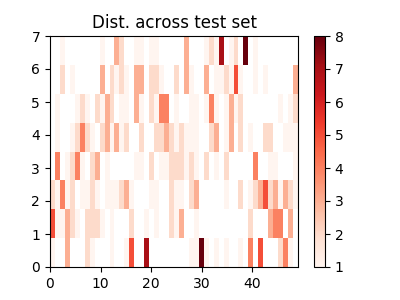

In [5]:
# we can do some visualizations to see how the spectral centroids (y-axis) are distributed across the original classes (x-axis)

f,l = fetch_files(dataset_path)
spec_l = [int(getStringMatch(i[::-1],"_",-1)) for i in f]

plt.figure(figsize=(4,3))
plt.hist2d(l,spec_l,[50,8],cmap='Reds',cmin=1)
plt.colorbar()
plt.title("Dist. across whole dataset")

plt.figure(figsize=(4,3))
plt.hist2d(train_labels,spec_train_labels,[50,8],cmap='Reds',cmin=1)
plt.colorbar()
plt.title("Dist. across training set")

plt.figure(figsize=(4,3))
plt.hist2d(test_labels,spec_test_labels,[50,8],cmap='Reds',cmin=1)
plt.colorbar()
plt.title("Dist. across test set")

In [6]:
def shuffle(dataset, labels):
    """Randomizes order of elements in input arrays"""
    import random
    permutation = np.random.permutation(labels[0].shape[0])
    shuffled_dataset = dataset[permutation,:,:]
    shuffled_source_labels = labels[0][permutation]
    shuffled_spec_labels = labels[1][permutation]
    return shuffled_dataset, shuffled_source_labels, shuffled_spec_labels

def read_image(data):
    """For an array of filenames load each image. Returns a numpy array"""
    images = np.array([np.array(ndimage.imread(fp).astype(float)) - 0.5 for fp in data])
    return images
    
def sort_by_fold(folds,images,labels):
    """Sort images and labels in the order of Pickzak's folds
    folds: the 'folds' output of fetch_files_kfold
    """
    fold_order = np.argsort(folds, kind="mergesort")
    sorted_images = images[fold_order] 
    sorted_labels = np.array(labels)[fold_order]
    return sorted_images, sorted_labels

def reformat(dataset, labels, n_labels, n_spec_labels):
    """Reformats to appropriate shape for covnet. Use 1-hot encoding for labels"""
    dataset = dataset.reshape((-1, IMAGE_HEIGHT, IMAGE_WIDTH, NUM_CHANNELS)).astype(np.float32)
    source_labels = (np.arange(n_labels) == labels[0][:,None]).astype(np.int32)
    spec_labels = (np.arange(n_spec_labels) == labels[1][:,None]).astype(np.int32)
    return dataset, source_labels, spec_labels

In [7]:
# finally read in the images, shuffle the datasets, and arrange in a tensorflow friendly array shape

train_set = read_image(train_filepaths)
train_label = np.array(train_labels)
spec_train_label = np.array(spec_train_labels)
train_set, train_label, spec_train_label = shuffle(train_set, [train_label,spec_train_label])
train_set, train_label, spec_train_label = reformat(train_set, [train_label,spec_train_label], m.N_LABELS, m.N_SPEC_LABELS)

test_set = read_image(test_filepaths)
test_label = np.array(test_labels)
spec_test_label = np.array(spec_test_labels)
test_set, test_label, spec_test_label = shuffle(test_set, [test_label,spec_test_label])
test_set, test_label, spec_test_label = reformat(test_set, [test_label,spec_test_label], m.N_LABELS, m.N_SPEC_LABELS)

print('Training set', train_set.shape, train_label.shape, spec_train_label.shape )
print('Test set', test_set.shape, test_label.shape, spec_test_label.shape)

Training set (1600, 37, 50, 1) (1600, 50) (1600, 8)
Test set (400, 37, 50, 1) (400, 50) (400, 8)


### Now train and test CNN

In [8]:
cwd = os.getcwd() #current working folder

# Parameters
batch_size = 20
epochs = 3000
display_epoch = 20 # display accuracy every display_epochs
num_steps = int(train_label.shape[0]/batch_size*epochs)
display_step = int(train_label.shape[0]/batch_size*display_epoch) 
#graph_step = 50

# Network Parameters
#learning_rate = 0.01
dropout = .5 # Dropout, probability to keep units
beta = 0.005 # L2-regularization

#********************************************************************
# we have 2 models: 1.multi-task learning (MTL) 2. single-task learning(STL)
# first let's define all variables needed for MTL
# for MTL we do 2 learning tasks simultaneously, classify audio sources (main task) and classify spectral centroids (secondary task)
# [pred1,prob1,accuracy1] refers to the main task and [pred2,prob2,accuracy2] is for the secondary task

# tf Graph input placeholders
x = tf.placeholder(tf.float32)
y1 = tf.placeholder(tf.int32)
y2 = tf.placeholder(tf.int32)
keep_prob = tf.placeholder(tf.float32) #dropout (keep probability)

# Construct model
pred1, pred2 = m.conv_net(x, m.weights, m.biases, keep_prob)

#L2 regularization
lossL2 = tf.add_n([tf.nn.l2_loss(val) for name,val in m.weights.items()]) * beta
      
# Define cost function
cost_mtl = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred1, labels=y1) +
                      tf.nn.softmax_cross_entropy_with_logits(logits=pred2, labels=y2) +
                      lossL2)

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred1, labels=y1) +
                      lossL2)
   
# Optimizer
optimizer_mtl = tf.train.AdamOptimizer().minimize(cost_mtl)
optimizer = tf.train.AdamOptimizer().minimize(cost)
  
# Predictions for the training, validation, and test data.
prob1 = tf.nn.softmax(pred1)
prob2 = tf.nn.softmax(pred2)
    
# Evaluate model
def accuracy(predictions, labels):
    correct_pred = tf.equal(tf.argmax(predictions, 1), tf.argmax(labels, 1))
    accuracy = 100*tf.reduce_mean(tf.cast(correct_pred, tf.float32))
    return accuracy
    
accuracy1 = accuracy(prob1,y1)
accuracy2 = accuracy(prob2,y2)

#save_all = tf.train.Saver() #create saver handle

In [9]:
# next we do the same for the STL model
# both models share the same network parameters

# Construct model
pred_stl = s.conv_net(x, s.weights, s.biases, keep_prob)

#L2 regularization
lossL2_stl = tf.add_n([tf.nn.l2_loss(val) for name,val in s.weights.items()]) * beta

# Define cost function
cost_stl = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred_stl, labels=y1) +
                      lossL2_stl)

# Optimizer
optimizer_stl = tf.train.AdamOptimizer().minimize(cost_stl)

# Predictions
prob_stl = tf.nn.softmax(pred_stl)

# Evaluate model
accuracy_stl = accuracy(prob_stl,y1)

In [10]:
# we run the models in parallel

# can save variables below for plotting with matplotlib later or use tensorboard
epoch_list = []     # epoch count
train_accs = []     # mtl main task training accuracy
test_accs = []      # mtl main task testing accuracy
spec_accs = []      # mtl secondary task training accuracy
spec_test_accs = [] # mtl secondary task testing accuracy
ls = []             # mtl combined loss value
ls_stl = []         # stl loss value
stl_train_accs = [] # stl training accuracy
stl_test_accs = []  # stl testing accuracy
total_runs = 1      # no. of separate runs

run = 0
start_time_long = time.monotonic()
text_file = open("./results/exp_v2.txt", "w")
while run < total_runs:
    with tf.Session() as session:
        # Merge all the summaries and write them out to /tmp/mnist_logs (by default)
        #merged = tf.summary.merge_all()
        #train_writer = tf.summary.FileWriter(cwd + '/results/stft/train',session.graph)
        #test_writer = tf.summary.FileWriter(cwd + '/results/stft/test')
        tf.global_variables_initializer().run()
        text_file.write('*** Initializing Run #%u ***\n' % run)
        print('*** Initializing Run #%u ***' % run)
        start_time = time.monotonic()

        for step in range(num_steps):
            offset = (step * batch_size) % (train_label.shape[0] - batch_size)
            batch_data = train_set[offset:(offset + batch_size), :, :, :]
            batch_labels = train_label[offset:(offset + batch_size),:]
            batch_spec_labels = spec_train_label[offset:(offset + batch_size),:]

            _, l, acc1, acc2 = session.run([optimizer_mtl, cost_mtl, accuracy1, accuracy2],
                                    feed_dict= {x:batch_data, y1:batch_labels, y2:batch_spec_labels, keep_prob:dropout})
            
            _, l_stl, acc_stl = session.run([optimizer_stl, cost_stl, accuracy_stl],
                                    feed_dict= {x:batch_data, y1:batch_labels, keep_prob:dropout})

            if (step % display_step == 0):
                #train_writer.add_summary(train_summary, step)
                e = int(step*batch_size/train_label.shape[0])
                text_file.write('MTL: loss at step %d, epoch %d: %f\n' % (step, e, l))
                text_file.write('STL: loss at step %d, epoch %d: %f\n' % (step, e, l_stl))
                text_file.write('MTL: Training- main task accuracy: %.1f%%, sec task accuracy: %.1f%%\n' % (acc1,acc2))
                text_file.write('STL: Training- main task accuracy: %.1f%%\n' % acc_stl)
                print('MTL: loss at step %d, epoch %d: %f' % (step, e, l))
                print('STL: loss at step %d, epoch %d: %f' % (step, e, l_stl))
                print('MTL: Training- main task accuracy: %.1f%%, sec task accuracy: %.1f%%' % (acc1,acc2))
                print('STL: Training- main task accuracy: %.1f%%' % acc_stl)
                
                test_acc1, test_acc2 = session.run([accuracy1, accuracy2],
                            feed_dict= {x:test_set, y1:test_label, y2:spec_test_label, keep_prob:1.}) #run model on test set
                
                test_acc_stl = session.run(accuracy_stl,
                            feed_dict= {x:test_set, y1:test_label, keep_prob:1.}) #run model on test set
                
                text_file.write('MTL: Test- main task accuracy: %.1f%%, sec task accuracy: %.1f%%\n' % (test_acc1, test_acc2))
                text_file.write('STL: Test- main task accuracy: %.1f%%\n' % test_acc_stl)
                text_file.write("------------------------\n")
                print('MTL: Test- main task accuracy: %.1f%%, sec task accuracy: %.1f%%' % (test_acc1, test_acc2))
                print('STL: Test- main task accuracy: %.1f%%' % test_acc_stl)
                print("------------------------")
                
                epoch_list.append(e)
                train_accs.append(acc1)
                spec_accs.append(acc2)
                test_accs.append(test_acc1)
                spec_test_accs.append(test_acc2)
                ls.append(l)
                ls_stl.append(l_stl)
                stl_train_accs.append(acc_stl)
                stl_test_accs.append(test_acc_stl)

#             if (step % graph_step == 0):
#                 steps.append(step)
#                 accs.append(acc)
#                 ls.append(l)

        #save_all.save(session, cwd + '/model3/data-all.chkp') #save model
        elapsed_time = time.monotonic() - start_time
        print("--- Training time taken:",time_taken(elapsed_time),"---")

        test_acc1, test_acc2 = session.run([accuracy1, accuracy2],
                            feed_dict= {x:test_set, y1:test_label, y2:spec_test_label, keep_prob:1.}) #run model on test set
        
        test_acc_stl = session.run(accuracy_stl,
                            feed_dict= {x:test_set, y1:test_label, keep_prob:1.}) #run model on test set
        #test_writer.add_summary(test_summary)
        text_file.write('MTL: Final- main task accuracy: %.1f%%, sec task accuracy: %.1f%%\n' % (test_acc1, test_acc2))
        text_file.write('STL: Final- main task accuracy: %.1f%%\n' % test_acc_stl)
        print('MTL: Final- main task accuracy: %.1f%%, sec task accuracy: %.1f%%' % (test_acc1, test_acc2))
        print('STL: Final- main task accuracy: %.1f%%' % test_acc_stl)

    run += 1

elapsed_time_long = time.monotonic() - start_time_long
print("*** All runs completed ***")
text_file.write("Total time taken:")
text_file.write(time_taken(elapsed_time_long))
print("Total time taken:",time_taken(elapsed_time_long))
text_file.close()

*** Initializing Run #0 ***
MTL: loss at step 0, epoch 0: 620.608826
STL: loss at step 0, epoch 0: 583.158508
MTL: Training- main task accuracy: 0.0%, sec task accuracy: 25.0%
STL: Training- main task accuracy: 5.0%
MTL: Test- main task accuracy: 3.2%, sec task accuracy: 17.5%
STL: Test- main task accuracy: 2.8%
------------------------
MTL: loss at step 1600, epoch 20: 8.331163
STL: loss at step 1600, epoch 20: 5.442678
MTL: Training- main task accuracy: 60.0%, sec task accuracy: 60.0%
STL: Training- main task accuracy: 70.0%
MTL: Test- main task accuracy: 44.2%, sec task accuracy: 53.7%
STL: Test- main task accuracy: 40.8%
------------------------
MTL: loss at step 3200, epoch 40: 5.961020
STL: loss at step 3200, epoch 40: 4.584316
MTL: Training- main task accuracy: 45.0%, sec task accuracy: 60.0%
STL: Training- main task accuracy: 45.0%
MTL: Test- main task accuracy: 44.5%, sec task accuracy: 56.8%
STL: Test- main task accuracy: 49.0%
------------------------
MTL: loss at step 4800,

In [5]:
#functions to save/load numpy arrays to/from file

def save_sets(sets,name):
    """Writes the data array to .npy file. Can be loaded using load_set.
    sets: arrays to be saved. can take a list
    name: string to name the file. follow same order as in sets 
    """ 
    ind = 0
    for x in sets:
        np.save('./results/{}.npy'.format(name[ind]), x)
        ind += 1

def load_set(sets):
    """Load existing data arrays from .npy files. Use if have preexisting data or when you don't to reshuffle the dataset"""
    return np.load('{}.npy'.format(sets))

In [6]:
epoch_list = np.array(epoch_list)
train_accs = np.array(train_accs)
test_accs = np.array(test_accs)
spec_accs = np.array(spec_accs)
spec_test_accs = np.array(spec_test_accs)
ls = np.array(ls)
ls_stl = np.array(ls_stl)
stl_train_accs = np.array(stl_train_accs)
stl_test_accs = np.array(stl_test_accs)

namelist = ['epoch_list','train_accs','test_accs','spec_accs','spec_test_accs','ls','ls_stl','stl_train_accs','stl_test_accs']

#save_sets([epoch_list,train_accs,test_accs,spec_accs,spec_test_accs,ls,ls_stl,stl_train_accs,stl_test_accs],namelist)

In [9]:
#let's load all our results to do some visualizations

epoch_list = load_set("./results/epoch_list")
train_accs = load_set("./results/train_accs")
test_accs = load_set("./results/test_accs")
spec_accs = load_set("./results/spec_accs")
spec_test_accs = load_set("./results/spec_test_accs")
ls = load_set("./results/ls")
ls_stl = load_set("./results/ls_stl")
stl_train_accs = load_set("./results/stl_train_accs")
stl_test_accs = load_set("./results/stl_test_accs")


### Plot and analyze results

<IPython.core.display.Javascript object>


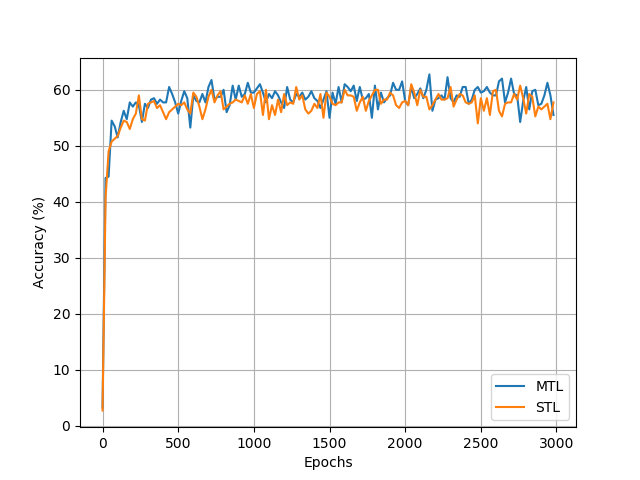

In [11]:
# Main task: MTL vs STL test performance

plt.figure()
plt.plot(epoch_list,test_accs)
plt.plot(epoch_list,stl_test_accs)
plt.ylabel("Accuracy (%)")
plt.xlabel("Epochs")
plt.legend(["MTL","STL"])
plt.grid()
plt.savefig('C:/Users/Huz/Documents/python_scripts/ESC50_multitask/results/MTL_vs_STL_test_performance.png')

<IPython.core.display.Javascript object>


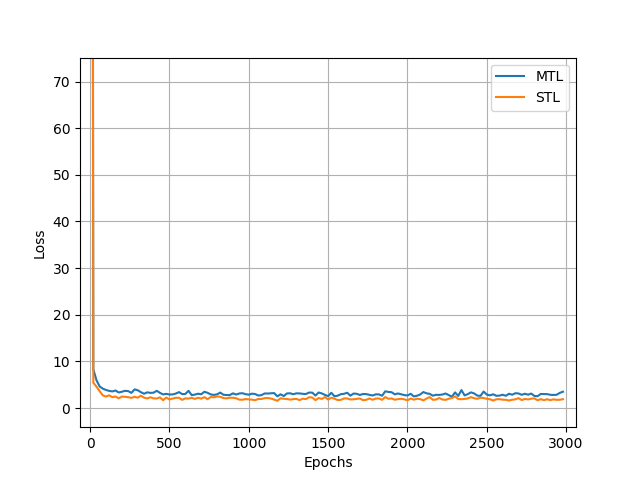

In [12]:
# Main task: MTL vs STL loss

plt.figure()
plt.plot(epoch_list,ls)
plt.plot(epoch_list,ls_stl)
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(["MTL","STL"])
plt.grid()
plt.savefig('C:/Users/Huz/Documents/python_scripts/ESC50_multitask/results/MTL_vs_STL_loss.png')

<IPython.core.display.Javascript object>


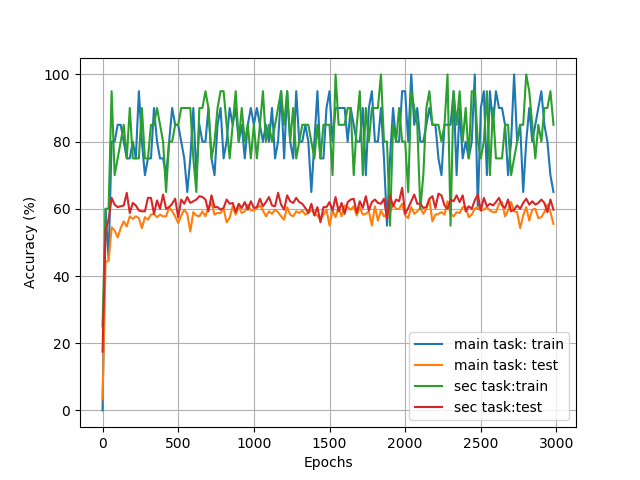

In [13]:
# Main task vs Sec task performance in MTL model

plt.figure()
plt.plot(epoch_list,train_accs)
plt.plot(epoch_list,test_accs)
plt.plot(epoch_list,spec_accs)
plt.plot(epoch_list,spec_test_accs)
plt.ylabel("Accuracy (%)")
plt.xlabel("Epochs")
plt.legend(["main task: train","main task: test","sec task:train","sec task:test"])
plt.grid()
plt.savefig('C:/Users/Huz/Documents/python_scripts/ESC50_multitask/results/Maintask_vs_Sectask_in_MTL.png')

<IPython.core.display.Javascript object>


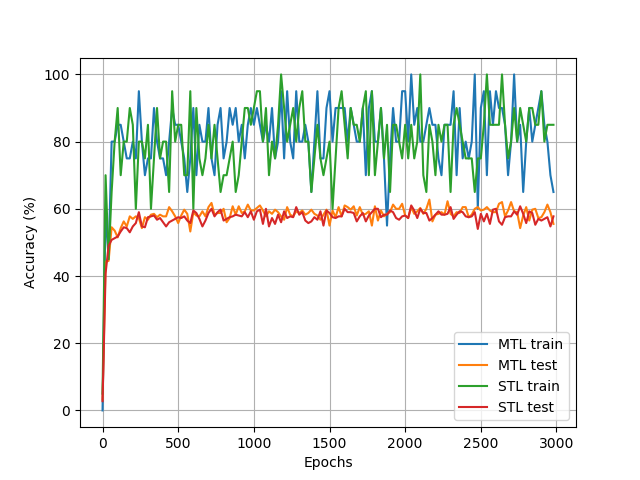

In [14]:
# Main task training vs test, on MTL and STL

plt.figure()
plt.plot(epoch_list,train_accs)
plt.plot(epoch_list,test_accs)
plt.plot(epoch_list,stl_train_accs)
plt.plot(epoch_list,stl_test_accs)
plt.ylabel("Accuracy (%)")
plt.xlabel("Epochs")
plt.legend(["MTL train","MTL test","STL train","STL test"])
plt.grid()
plt.savefig('C:/Users/Huz/Documents/python_scripts/ESC50_multitask/results/Maintask_training_vs_test_on_MTL_and_STL.png')